In [1]:
import pygame
import sys
import time
import random

import pygame.locals as pgl

import numpy as np

import networkx as nx
import epydemic

from custom_disease_model import Kennels, DistemperModel
# from aggregate_visualization import AggregatePlot

from copy import copy, deepcopy

from threading import Thread

import logging

import multiprocessing
from multiprocessing import Pool

import tqdm

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from matplotlib import cm

from interventions import SortIntervention, TimedRemovalIntervention, RoomLockIntervention

class Simulation(object):
    
    def __init__(self, params, spatial_visualization=True, aggregate_visualization=True, return_on_equillibrium=False):
        self.return_on_equillibrium = return_on_equillibrium
        self.spatial_visualization = spatial_visualization
        self.aggregate_visualization = aggregate_visualization

        if not self.spatial_visualization and not self.aggregate_visualization and not self.return_on_equillibrium:
            logging.warning('Warning: No visualizations were set, it is highly recommended you set return_on_equillibrium to True otherwise you will have to manually manage the simulation state.')

        self.params = params
        if 'infection_kernel_function' in self.params and type(self.params['infection_kernel_function']) == str:
            self.params['infection_kernel_function'] = eval(self.params['infection_kernel_function'])
        else:
            self.params['infection_kernel_function'] = lambda node, k: 0.0
        if 'intervention' in self.params and type(self.params['intervention']) == str:
            self.params['intervention'] = eval(self.params['intervention'])
        else:
            self.params['intervention'] = None
        self.kennels = Kennels()
        self.disease = DistemperModel(self.kennels.get_graph(), self.params)

        self.update_hooks = []

#         if spatial_visualization:
#             self.FPS = 0
#             self.SCREEN_WIDTH, self.SCREEN_HEIGHT = 640, 480
#             pygame.init()
#             self.fpsClock = pygame.time.Clock()
#             self.screen = pygame.display.set_mode((self.SCREEN_WIDTH, self.SCREEN_HEIGHT), 0, 32)
#             self.surface = pygame.Surface(self.screen.get_size())
#             self.surface = self.surface.convert()
#             self.surface.fill((255,255,255))
#             self.clock = pygame.time.Clock()

#             pygame.key.set_repeat(1, 40)
        
#             self.screen.blit(self.surface, (0,0))

#             self.font = pygame.font.Font(None, 36)
        
#         if aggregate_visualization:
#             self.plt = AggregatePlot(self.disease, self.kennels)
#             self.update_hooks.append(self.plt.update)

    def check_events(self):
        for event in pygame.event.get():
            if event.type == pgl.QUIT:
                pygame.quit()
                sys.exit()
            elif event.type == pgl.KEYDOWN:
                if event.key == pgl.K_ESCAPE:
                    pygame.quit()
                    sys.exit()

    def redraw(self):
        self.screen.blit(self.surface, (0,0))
        pygame.display.flip()
        pygame.display.update()
        self.fpsClock.tick(self.FPS)

    def draw_ui(self):
        text = self.font.render('{0} days, {1} hours'.format(int(np.floor(self.disease.t/24.0)), self.disease.t%24), 1, (10, 10, 10))
        textpos = text.get_rect()
        textpos.centerx = 200
        self.surface.blit(text, textpos)

    def get_disease_state(self):
        return {sc: len(self.disease.get_state_node(sc)['members']) for sc in self.disease.id_map.keys()}
        
    def update(self):
        if self.spatial_visualization:
            self.check_events()
            self.surface.fill((255,255,255))

        if not self.disease.in_equilibrium():
            if 'intervention' in self.params and self.params['intervention'] != None:
                self.params['intervention'].update(simulation=self)
            self.disease.update(self.kennels)
        elif self.return_on_equillibrium:
            self.running = False
            return

        for hook in self.update_hooks:
            print(hook)
            hook()
        
        if self.spatial_visualization:
            self.kennels.draw(self.surface, self.disease)
            self.draw_ui()
            self.redraw()
    
    def stop(self):
        self.running = False

    def run(self, asynchronous=False):
        self.running = True
        if asynchronous:
            self.async_thread = Thread(target=self.run, args=(False,))
            self.async_thread.start()
        else:
            while self.running:
                self.update()
            return self.get_disease_state()

class BatchSimulation(object):
    def __init__(self, params, runs, pool_size=-1):
        self.params = params
        self.runs = runs
        if pool_size == None:
            self.pool_size = 1
        elif pool_size <= 0:
            self.pool_size = multiprocessing.cpu_count()
        
    def run(self):
        results = []
        with Pool(self.pool_size) as p:
            for i in tqdm.tqdm(p.imap_unordered(BatchSimulation.run_simulation, [deepcopy(self.params) for _ in range(0, self.runs)]), total=self.runs):
                results.append(i)
            p.close()
            p.join()
        return results
            
    @staticmethod
    def run_simulation(params):
        return Simulation(params, spatial_visualization=False, aggregate_visualization=False, return_on_equillibrium=True).run()

def main(batch=False):
    params = {
            'pIntake': 0.25,
            'pInfect': 0.04,
            'pSurvive': 0.0025,
            'pDie': 0.0058333333333333,
            'pDieAlternate': 0.0,
            'refractoryPeriod': 3.0*24.0,
            'infection_kernel': [0.5, 0.25],
            'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
            'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
            'intervention': 'SortIntervention()'
        }
    if not batch:
        sim = Simulation(params, spatial_visualization=True, return_on_equillibrium=False, aggregate_visualization=False)
#         print(sim.run())
    else:
        runs = 32
        bar_width = 0.35
        proportion = True
        colors = [cm.jet(0), cm.jet(0.5)]
        alphas = [0.5, 0.25]
        labels = ['Sort Intervention', 'No Intervention']
        
        params1 = copy(params)
        params1['intervention'] = None
        
        results = BatchSimulation(params, runs).run()

        total = sum(list(results[0].values()))
        df = pd.DataFrame.from_records(results)
        if proportion:
            df /= total
        
        plt.rcdefaults()

        objects = df.columns
        y_pos = np.arange(len(objects))
        
        plt.bar(y_pos-bar_width/2, df.mean(), bar_width, align='center', alpha=alphas[0], yerr=df.std()/np.sqrt(len(df)), color=colors[0], label=labels[0])
        
        results = BatchSimulation(params1, runs).run()
        df = pd.DataFrame.from_records(results)
        if proportion:
            df /= total
        plt.bar(y_pos+bar_width/2, df.mean(), bar_width, align='center', alpha=alphas[1], yerr=df.std()/np.sqrt(len(df)), color=colors[1], label=labels[1])

        plt.xticks(y_pos, objects)
        plt.ylabel('Mean Animal Count')
        plt.ylim(0, 1)
        plt.title('Average Simulation Performance')
        plt.legend()

        plt.show()
    

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def average_simulation(params,runs=10,simulation_time=np.arange(1,10)):
    """ Script to run simulation with a specific type of intervention multiple times and average the data 
        
        Arguments:
            params {dict} -- current parameter settings
            runs {int} -- number of times to run simulation and then averaged
            simulation_time {array} -- how long to run simulation for
        Outputs:
            results {pandas.core.groupby.DataFrameGroupBy} -- results grouped by day with each column as a state (i.e. D,E,etc)
    """
    
    for run in range(runs):
        if run == 0: 
            sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)
        else: 
            del(sim)
            sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)
        df_tmp = pd.DataFrame(sim.get_disease_state(),index=[0])
        for simul_time in simulation_time:
            sim.update()
            tmp = pd.DataFrame(sim.get_disease_state(),index=[simul_time])
            df_tmp = df_tmp.append(tmp)
            try:
                df_concat = df_concat.append((tmp))
            except:
                df_concat = df_tmp
    results = df_concat.groupby(df_concat.index)
    return results

In [3]:
def error_function(optimize_params, time, actual_data, runs):
    """ Model to calculate the difference between simulated and actual data (need to pick category to define error)
            or technically could make some linear combination of all categories
        Arguments:
            optimize_params {dictionary} -- list of parameters to use in optimization
            time {array} -- time length of simulation
            actual_data {array} -- array of data from real simulation
            runs {int} -- # of runs to average over
        Outputs:
            error {float} -- inner product between two curves
    """
    
    params = {
        'pIntake': optimize_params['pIntake'],
        'pInfect': optimize_params['pInfect'],
        'pSurvive': optimize_params['pSurvive'],
        'pDie': optimize_params['pDie'],
        'pDieAlternate': optimize_params['pDieAlternate'],
        'refractoryPeriod': optimize_params['refractoryPeriod'],
        'infection_kernel': [0.5, 0.25],
        'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
        'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
        'intervention': 'SortIntervention()'
    }
    results = average_simulation(params,runs,time)
    empty_results = results.E.mean()
    infected_results = results.I.mean()
    simulated_data = infected_results
#     actual_data = np.ones(len(simulated_data))
    diff = simulated_data - actual_data
    return diff

In [3]:
# Parameter fitting based on real data
from lmfit import Minimizer, Parameters, report_fit

params = {
        'pIntake': 0.8,
        'pInfect': 0.04,
        'pSurvive': 0.0025,
        'pDie': 0.58333333333333,
        'pDieAlternate': 0.0025,
        'refractoryPeriod': 3.0*24.0,
        'infection_kernel': [0.5, 0.25],
        'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
        'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
        'intervention': 'SortIntervention()'
    }

# Add parameters to try and optimize
optimize_params = Parameters()
optimize_params.add('pIntake',value=params['pIntake'], min=0)
optimize_params.add('pInfect',value=params['pInfect'], min=0)
optimize_params.add('pSurvive',value=params['pSurvive'], min=0)
optimize_params.add('pDie',value=params['pDie'], min=0)
optimize_params.add('pDieAlternate',value=params['pDieAlternate'], min=0)
optimize_params.add('refractoryPeriod',value=params['refractoryPeriod'], min=0)

time = np.arange(0,10)
# Put in actual data when get it
data = 96*np.random.rand(len(time))
data = tmp[:len(time)]
runs = 10
# do fit, here with leastsq model
minner = Minimizer(error_function, optimize_params, fcn_args=(time, data, runs))
result = minner.minimize()

NameError: name 'tmp' is not defined

In [ ]:
# calculate final result
final = data + result.residual

# write error report
report_fit(result)

# try to plot results
try:
    import matplotlib.pyplot as plt
    plt.plot(time, data, 'k+')
    plt.plot(time, final, 'r')
    plt.show()
except ImportError:
    pass

In [4]:
#
params['intervention'] = 'TimedRemovalIntervention()'
sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)

In [82]:
# Examine Spatial Resolution of infected
# data_node is where index: 0=simul, 1=kennel #, 2=time 
import time
start = time.time()
params['intervention'] = 'TimedRemovalIntervention()'
sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)
time_range = np.arange(0,20)
position = np.arange(min(sim.disease.graph.nodes),max(sim.disease.graph.nodes)+1)
simulations = 100
data_node = np.zeros((simulations,len(position),len(time_range)))

for simul in range(simulations):
    for simul_time in time_range:
        sim.update()
        for _,data in sim.disease.graph.nodes(data=True):
            if data['data']['occupant'] != None:
                data_node[simul,data['data']['node_id'],simul_time] += data['data']['occupant']['state']
end = time.time()
print("Elapsed Time: ",end-start)

Elapsed Time:  15.229734897613525


In [83]:
# Get various averages
# Average across simulations
simul_avg_data_node= np.mean(data_node,axis=0)
# Average over time for a particular kennel
time_avg_data_node = np.mean(simul_avg_data_node,axis=1)


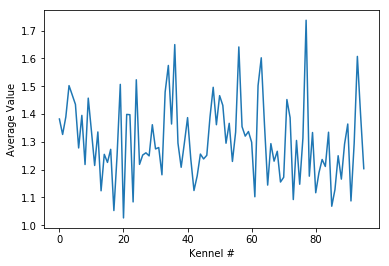

In [84]:
# Plot time average
fig, ax = plt.subplots()
ax.plot(time_avg_data_node)
ax.set_xlabel('Kennel #')
ax.set_ylabel('Average Value')

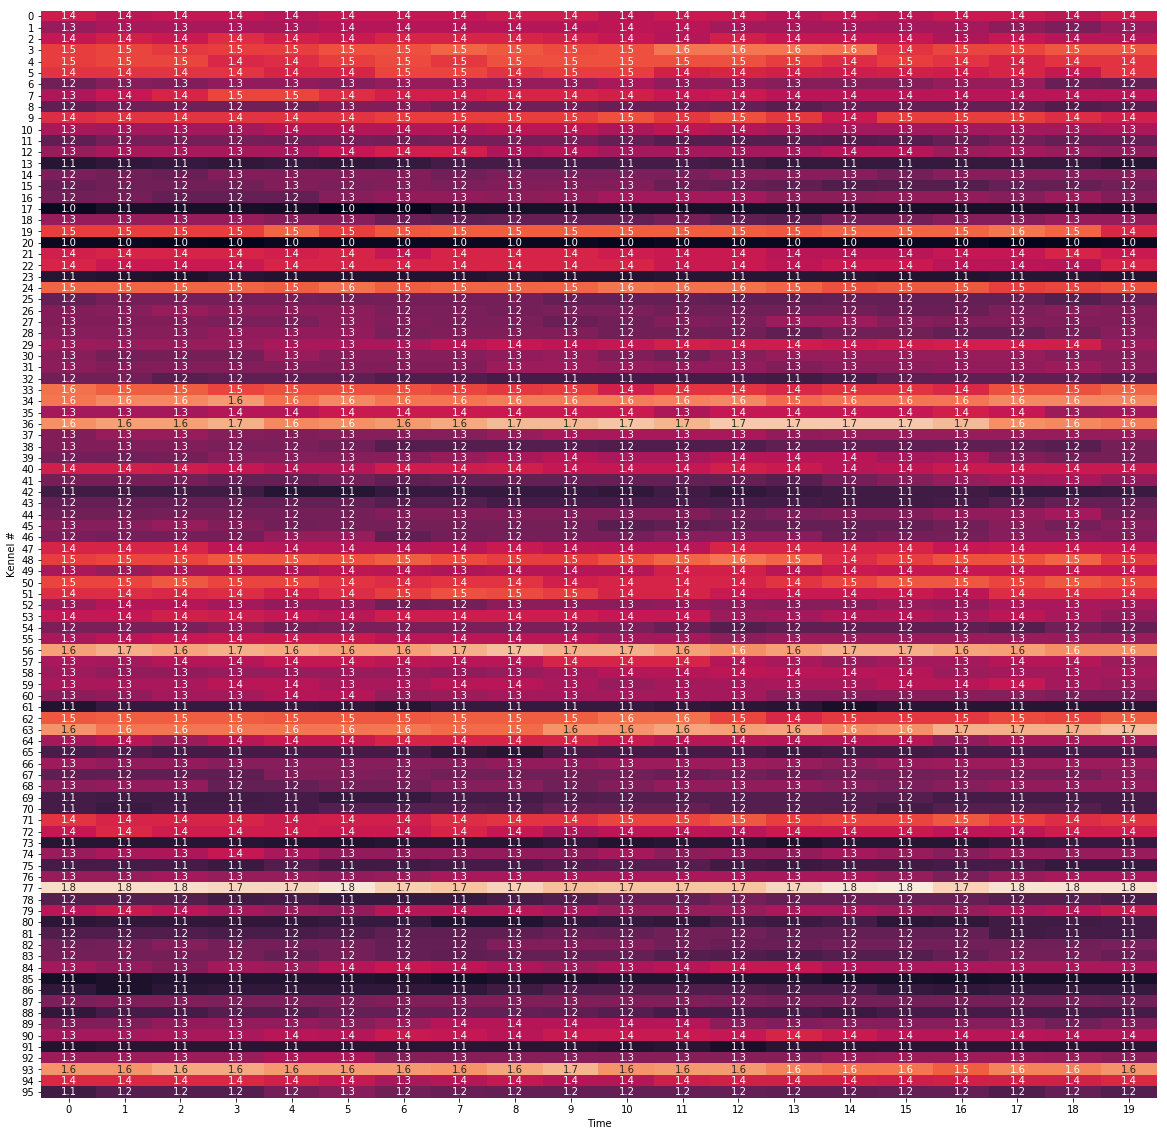

In [85]:
# Plot time series average at each kennel
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(simul_avg_data_node,ax=ax,square=False,annot=True,fmt='.1f',cbar=False)
ax.set_xlabel('Time')
ax.set_ylabel('Kennel #')

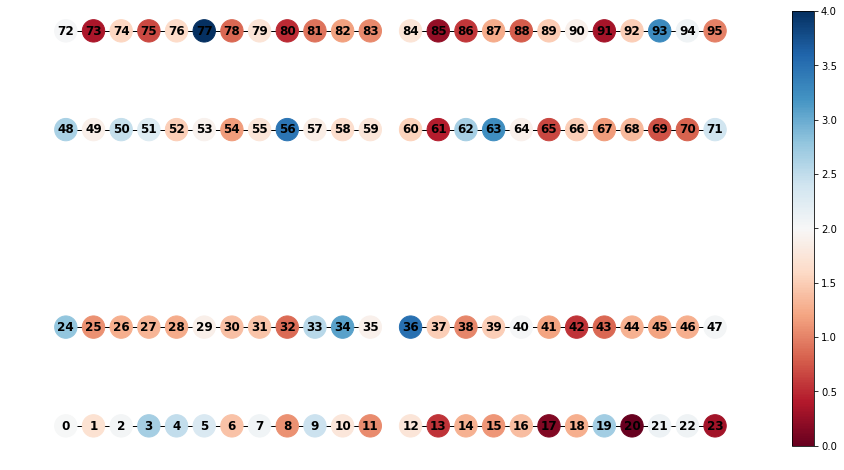

In [86]:
# Draw nodes with time average data
fig, ax = plt.subplots(figsize=(16,8))

# Get positions of nodes
pos = {}
for _,node in sim.disease.graph.nodes(data=True):
    pos[node['data']['node_id']] = node['data']['center']
    
# For creating colorbars
cmap = 'RdBu'
# 0 is None, 1 is , 2 is , 3 is , 4 is 
vmin = 0
vmax = 4
plot1 = nx.draw(sim.disease.graph,with_labels=True, font_weight='bold',pos=pos,node_shape='o',
        node_color=time_avg_data_node,cmap=cmap,ax=ax,node_size=500,font_color='k')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)

In [87]:
# Calculate correlation matrix using speedup algorithm
correl = np.zeros(len(time_range))
count = np.zeros(len(time_range))
tau_range = np.arange(0,10)
assert np.max(tau_range) < np.max(time_range), "tau_max > time_max"
start = time.time()
count = np.zeros((simulations,len(position),len(position),len(tau_range)))
correl = np.zeros((simulations,len(position),len(position),len(tau_range)))

# data_node = np.zeros((simulations,len(position),len(time_range)))
for simul in range(simulations):
    for kdx, simul_time in enumerate(time_range):
        for tau in tau_range:
            if kdx + tau > np.max(time_range): continue
            count[simul,:,:,tau] += 1
            # Use matrix multiplication
            correl[simul,:,:,tau] += np.dot(np.reshape(data_node[simul,:,kdx+tau],[-1,1])\
                                             ,np.reshape(data_node[simul,:,kdx],[1,-1]))

correlations = correl / count
end = time.time()
print(end-start)
# plt.plot(correl/count)

0.9872949123382568


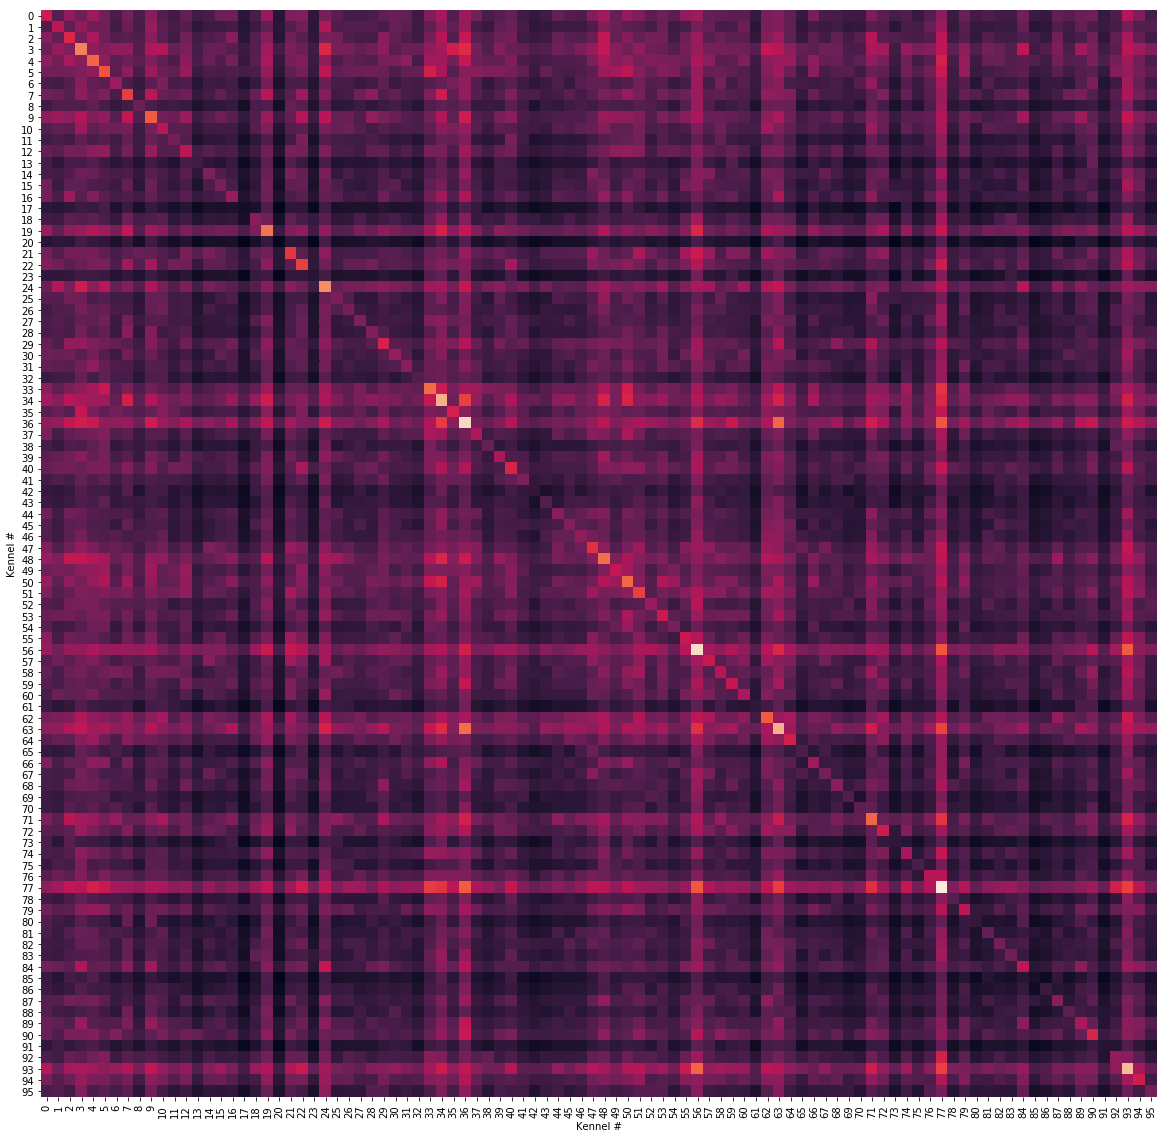

In [89]:
# Plot correlation as heatmap
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,20))
ax = np.ravel(ax)
tau_values = [0,2,4,6]
for idx,aa in enumerate(ax):
    sns.heatmap(np.mean(correlations,axis=0)[:,:,tau_values[3]],ax=aa,square=False,cbar=False,\
               xticklabels=position,yticklabels=position)
    aa.set_xlabel('Kennel #')
    aa.set_ylabel('Kennel #')

In [99]:
# Calculate infection correlations
# Find which kennels are infected, assign value of 1 otherwise 0 then find time correlation from this
infected_data = np.where(data_node == 3)
infection = np.zeros(data_node.shape)
infection[infected_data] = 1

tau_range = np.arange(0,10)
assert np.max(tau_range) < np.max(time_range), "tau_max > time_max"
start = time.time()
infection_count = np.zeros((simulations,len(position),len(position),len(tau_range)))
infection_correl = np.zeros((simulations,len(position),len(position),len(tau_range)))

for simul in range(simulations):
    for kdx, simul_time in enumerate(time_range):
        for tau in tau_range:
            if kdx + tau > np.max(time_range): continue
            infection_count[simul,:,:,tau] += 1
            # Use matrix multiplication
            infection_correl[simul,:,:,tau] += np.dot(np.reshape(infection[simul,:,kdx+tau],[-1,1])\
                                             ,np.reshape(infection[simul,:,kdx],[1,-1]))

infection_correlations = infection_correl / infection_count
end = time.time()
print(end-start)
# plt.plot(correl/count)

0.9467787742614746


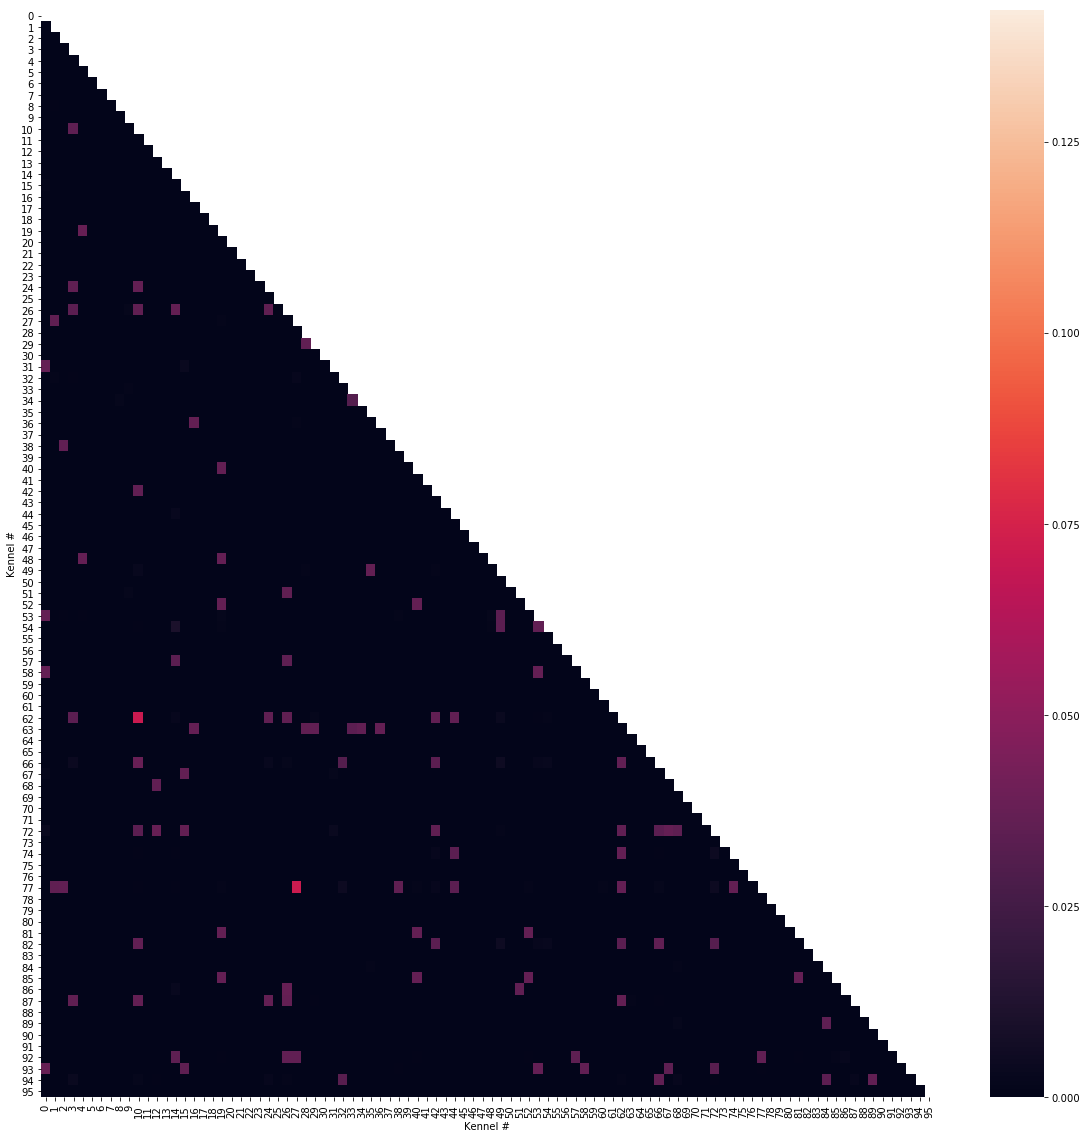

In [104]:
# Plot infection correlation as heatmap
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,20))
ax = np.ravel(ax)
tau_values = [0,2,4,6]
mask = np.zeros_like(np.mean(infection_correlations,axis=0)[:,:,0])
mask[np.triu_indices_from(mask)] = True
for idx,aa in enumerate(ax):
    sns.heatmap(np.mean(infection_correlations,axis=0)[:,:,tau_values[1]],ax=aa,square=False,cbar=True,\
               xticklabels=position,yticklabels=position,mask=mask)
    aa.set_xlabel('Kennel #')
    aa.set_ylabel('Kennel #')

3.0

In [6]:
params['intervention'] = 'TimedRemovalIntervention()'
sim = Simulation(params, spatial_visualization=False, return_on_equillibrium=True, aggregate_visualization=False)

In [6]:
def reset_params():
    params = {
        'pIntake': 0.8,
        'pInfect': 0.04,
        'pSurvive': 0.0025,
        'pDie': 0.58333333333333,
        'pDieAlternate': 0.0,
        'refractoryPeriod': 3.0*24.0,
        'infection_kernel': [0.5, 0.25],
        'infection_kernel_function': 'lambda node, k: k*(1-node[\'occupant\'][\'immunity\'])',
        'immunity_growth_factors': [1.03, 0.001], # _[0]*immunity+_[1]
        'intervention': 'SortIntervention()'
    }
    return params

In [55]:
# Run simulation multiple times and average results for each type of intervention
import time
start = time.time()
results = {}
simulation_time = np.arange(1,15)
runs = 50
Interventions = [None] # ['SortIntervention()','RoomLockIntervention()']
Interventions = ['TimedRemovalIntervention()',None] #,'RoomLockIntervention()']
param_list = np.linspace(0.01,0.85,15)
param_keys = ['pDie','pDieAlternate','pInfect','pIntake','pSurvive']
for intervention in Interventions:
    results[intervention] = {}
    params['intervention'] = intervention
    for key in param_keys:
        results[intervention][key] = {}
        params = reset_params()
        for param in param_list: 
            params[key] = param
            results[intervention][key][param] = average_simulation(params,runs,simulation_time)
end = time.time()
print("Elapsed Time: ",end-start)

Elapsed Time:  1859.866374015808


In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import scipy
from scipy import minimize

/mnt/c/Users/Awesome/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


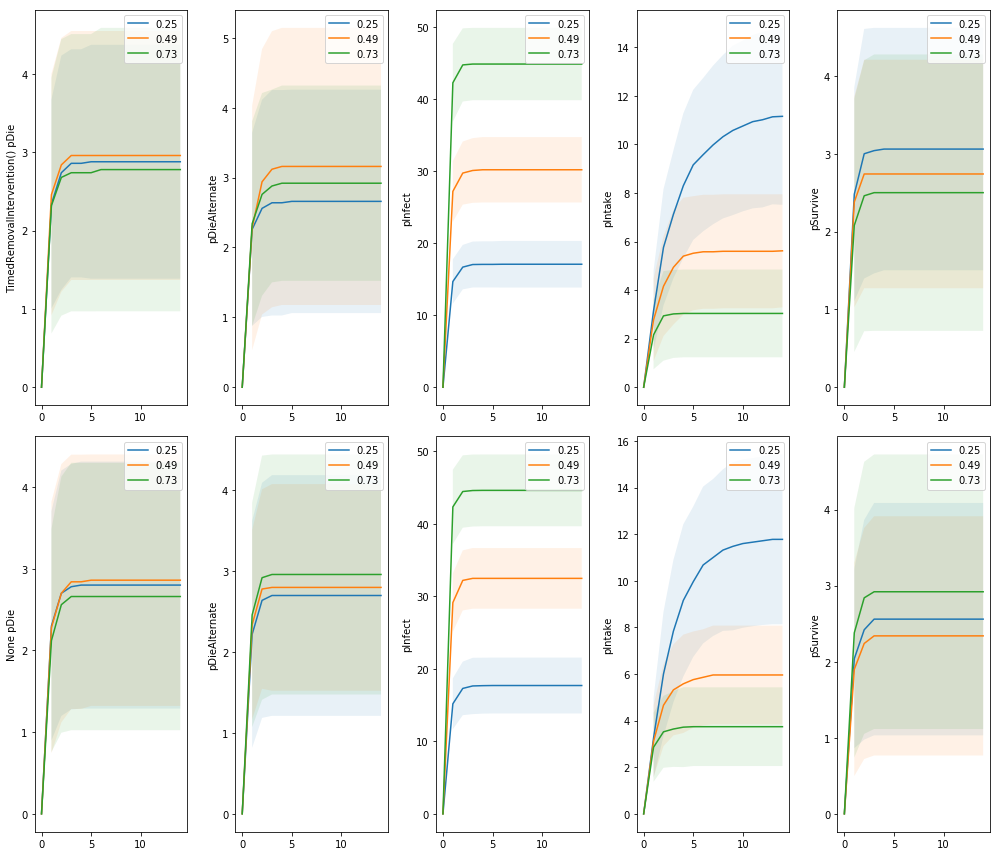

In [59]:
# Plot each simulation with the varying parameter list
# Each row represents an intervention type
# Each column is a different parameter from the list
# Legend shows the values over which parameter varies
ncols = len(param_keys)
nrows = len(Interventions)
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(14,12))

for idx,intervention in enumerate(Interventions):
    for jdx,key in enumerate(param_keys):
        for kdx,param in enumerate(param_list):
            if kdx % 4 != 0 or kdx == 0: continue
            x = results[intervention][key][param].mean()['I'].index
            y = results[intervention][key][param]
            y_low = y.mean()['I'].values - y.std()['I'].values
            y_high = y.mean()['I'].values + y.std()['I'].values
            ax[idx,jdx].plot(x,y.mean()['I'].values,label=param)
            ax[idx,jdx].fill_between(x,y_low,y_high,alpha=0.1)
        if jdx == 0:
            ax[idx,jdx].set_ylabel('{} {}'.format(intervention,key))
        else:
            ax[idx,jdx].set_ylabel('{}'.format(key))
        ax[idx,jdx].legend()
fig.set_tight_layout('tight')

In [15]:
len(results['TimedRemovalIntervention()'])

5

In [64]:
# Want data where each row represents a time and each column represent the infected value
data = np.zeros((len(pSurvive_list),(len(simulation_time)+1)))
for idx,k in enumerate(results['TimedRemovalIntervention()'].keys()):
    mean_values = results['TimedRemovalIntervention()'][k].mean()['I'].values
    for jdx,mean_value in enumerate(mean_values):
        data[idx,jdx] = mean_value
# Add zero to front of time arrayas not initiall included
simul_time = np.insert(simulation_time,0,0)
sx = simulation_time.size+1
sy = pSurvive_list.size
time_array = np.tile(simul_time, (sy,1))
survive_array = np.tile(pSurvive_list, (sx,1)).T

In [65]:
# Make sure all data is same size
data.shape, time_array.shape, survive_array.shape

((10, 50), (10, 50), (10, 50))

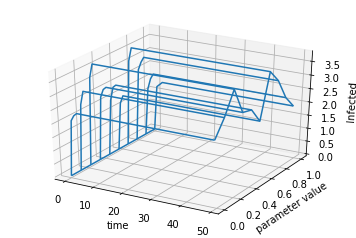

In [70]:
# Plot where x is time, y is parameter value, z is mean infected
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_wireframe(time_array, survive_array, data, cstride=1000)
ax.set_xlabel('time')
ax.set_ylabel('parameter value')
ax.set_zlabel('Infected')

/mnt/c/Users/Awesome/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


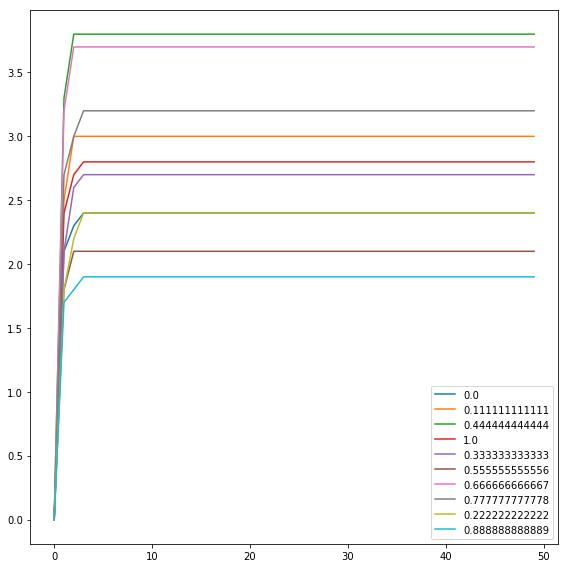

In [67]:
# Plot in 2D representation
fig, ax = plt.subplots(figsize=(8,8))
timed_results = results['TimedRemovalIntervention()']

for key in timed_results.keys():
    tmp = timed_results[key].mean()['I'].values
    ax.plot(tmp,label=key)
ax.legend()
fig.set_tight_layout('tight')

In [57]:
def num_infected(params,runs,simulation_time):
    ''' Find the total number of animals infected
        Arguments:
            
        Outputs:
            total_infected {float} --
    '''
    results = average_simulation(params,runs,simulation_time)
    num_infected = results.mean()['I'].values
    total_infected = np.sum(num_infected)
    return total_infected

In [60]:
params

{'immunity_growth_factors': [1.03, 0.001],
 'infection_kernel': [0.5, 0.25],
 'infection_kernel_function': <function __main__.Simulation.__init__.<locals>.<lambda>>,
 'intervention': None,
 'pDie': 0.58333333333333,
 'pDieAlternate': 0.0,
 'pInfect': 0.04,
 'pIntake': 0.8,
 'pSurvive': 0.84999999999999998,
 'refractoryPeriod': 72.0}

IndexError: too many indices for array

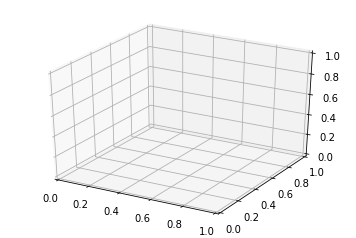

In [15]:
# Try to minimize infected by changing parameters
import scipy
from scipy import optimize

runs = 2
simulation_time = np.arange(1,10)
initial_guess = 
scipy.optimize.minimize(num_infected,initial_guess,args=(runs,simulation_time))

(50, 4)

In [18]:
verts = []
simul_time = np.arange(0,50)
for idx,pSurvive in enumerate(pSurvive_list):
    verts.append(list(zip(simul_time,data[:,idx])))
poly = PolyCollection(verts,facecolors=(1,1,1,1), edgecolors=(0,0,1,1))
poly.set_alpha(0.7)

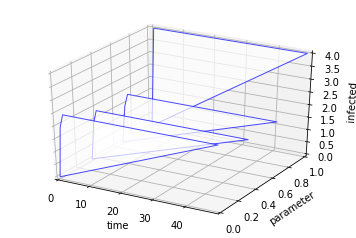

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.add_collection3d(poly,zs=pSurvive_list,zdir='y')

ax.set_xlim3d(0, np.max(simulation_time))
ax.set_xlabel('time')
ax.set_ylim3d(0, 1)
ax.set_ylabel('parameter')
ax.set_zlim3d(0,np.max(data))
ax.set_zlabel('infected')

In [60]:
np.shape(verts)

(500, 10, 2)

In [42]:
# Plot 3D plot where x is time axis, y is parameter, z is mean of a column
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
Fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
tmp = np.zeros((len(pSurvive_list),len(simulation_time)))
for idx,pSurvive in enumerate(pSurvive_list):
    for jdx,time in enumerate(simulation_time):
        tmp[idx,jdx] = results['TimedRemovalIntervention()'][pSurvive].mean()['I'].values[jdx]
# ax.scatter(simulation_time,pSurvive_list,tmp)
ax.imshow(tmp)

In [37]:
# plt.rcParams

/mnt/c/Users/Awesome/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


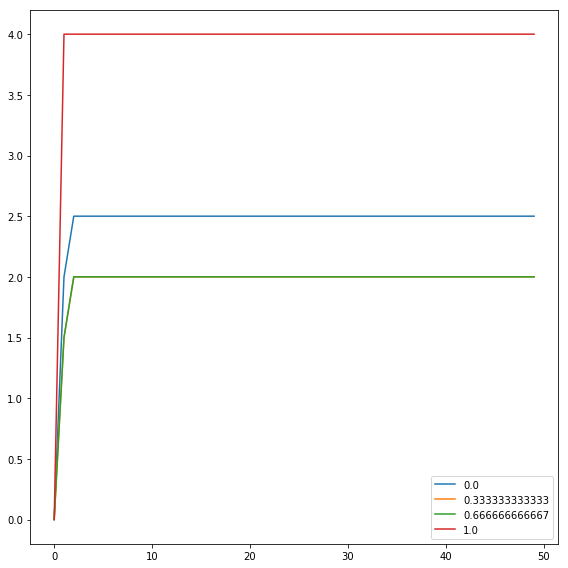

In [20]:
Fig, ax = plt.subplots(figsize=(8,8))
timed_results = results['TimedRemovalIntervention()']

for key in timed_results.keys():
    tmp = timed_results[key].mean()['I'].values
    ax.plot(tmp,label=key)
ax.legend()
Fig.set_tight_layout('tight')

/mnt/c/Users/Awesome/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


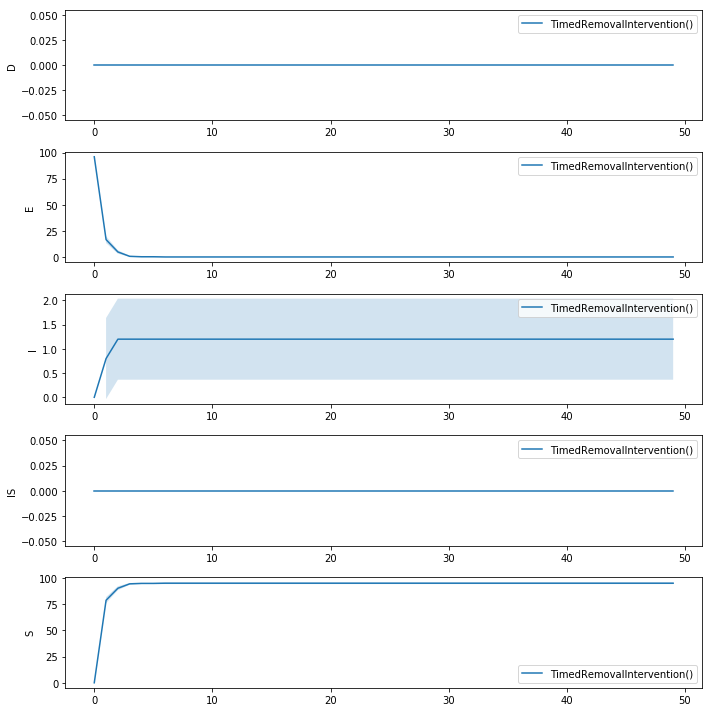

In [10]:
Fig, ax = plt.subplots(5,figsize = (10,10))
for intervention in Interventions:
    df_means = results[intervention].mean()
    df_std = results[intervention].std()
    x = np.array(df_means.index)
    for idx,col in enumerate(df_means.columns):
        y = df_means[col]
        y_low = df_means[col] - df_std[col]
        y_high = df_means[col] + df_std[col]
        ax[idx].plot(x,y,label=intervention)
        ax[idx].fill_between(x,y_low,y_high,alpha=0.2)
        ax[idx].set_ylabel(col)
        
for aa in ax:
    aa.legend()
Fig.set_tight_layout('tight')

In [ ]:
add in axis for param value

In [ ]:
use TimedIntervention

In [ ]:
debug with pycharmm